In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
 
sys.path.append("../include/")
import hhtools

In [110]:



# get_net_freq(obj)

In [4]:


def draw_contour(im_frs, ax, max_fr=10):
    fr = np.arange(max_fr)
    c = ax.contour(x, y, im_frs, frs, linewidths=3, alpha=0.9, cmap="gray", nchunk=5)
    ax.clabel(c, inline=1, fontsize=10)
    
    return c


def extract_line(imgs, x, y, c, target_value):
    
    xc, yc = [], []
    for p in c.collections[target_value].get_paths():
        v = p.vertices
        xc.extend(v[:,0])
        yc.extend(v[:,1])
    xc = np.array(xc)
    yc = np.array(yc)
    # sort
    ind = np.argsort(xc)
    xc = xc[ind]
    yc = yc[ind]
    
    lines = []
    for im in imgs:
        l, xq, yq = hhtools.extract_value_on_line(im, x, y, xc, yc)
        lines.append(l)
        
    return lines, xq, yq


def draw_line_summary(lines, xq, yq, dpi=120, figsize=(12, 3), ylims=None):
    fig, axs = plt.subplots(1, 5, dpi=dpi, figsize=figsize)
    axs[0].plot(xq, yq, 'k.-')
    axs[0].set_xlabel("x", fontsize=16)
    axs[1].set_xlabel("x", fontsize=16)
    
    var_names = ["", "chi", "cv", "frs_m", "net_freq"]
    for n, l in enumerate(lines, start=1):
        plt.axes(axs[n])
        plt.plot(xq, l)
        plt.title(var_names[n], fontsize=16)
        plt.xlabel("x", fontsize=16)
        
        if n == 1:
            yt = list(plt.yticks()[0])
            if yt[0] > 0.1:
                yt = [0] + yt        
            plt.yticks(yt)
        
    plt.tight_layout()
    
    return axs


def draw_detail(data, xl=(500, 2500)):
    N = len(data['step_spk'])

    fig, axs = plt.subplots(2,2, dpi=120, figsize=(10, 6), height_ratios={0.4, 0.6}, width_ratios={0.8, 0.2})
    # fig, axs = plt.subplots(2,2, dpi=120, figsize=(10, 6))
    plt.axes(axs[0][0])
    hhtools.plot_sub(data['ts']*1e3, data['vlfp'][0], xl=(500, 2500), c='k')
    plt.ylabel(r"$V$", fontsize=15)

    plt.axes(axs[0][1])
    vm = data["vlfp"][0]; t  = data["ts"]
    idt = (t > xl[0]/1000) & (t < xl[1]/1000)
    vm = vm[idt]
    t = t[idt]

    xcorr, tlags = hhtools.get_autocorr(vm, t, 0.2)
    plt.plot(tlags, xcorr, 'k', lw=1.2)
    plt.ylabel("auto corr", fontsize=13)

    plt.axes(axs[1][0])
    hhtools.draw_spk(data['step_spk'], xl=xl, color_ranges=[N*0.8, N], colors=['r', 'b'])
    plt.ylim([0, N])

    plt.axes(axs[1][1])
    frs = []
    tlen, dt = 2, 0.01
    for t in data["step_spk"]:
        t_spk = np.array(t) * dt
        t_spk = t_spk[t_spk > 500]
        frs.append(len(t_spk)/tlen)

    plt.hist(frs, 15, edgecolor='k')
    plt.ylabel("firing rate (Hz)", fontsize=13)

    plt.show()
    
    
def get_nearest_point(obj, x0, y0, x, y):
    n1 = np.argmin(np.abs(y - y0))
    n2 = np.argmin(np.abs(x - x0))
        
    print("chi:", obj.summary["chi"][n1, n2, 0])
    print("frs:", obj.summary["frs_m"][n1, n2, 0])
    print("cvs:", obj.summary["cv"][n1, n2, 0])
    
    return obj.load_detail(n1, n2, 0)

In [ ]:
x = obj.controls["nu_ext"]
y = obj.controls["p_inh"]

nid = 15
n1 = np.argmin(np.abs(y - yq[nid]))
n2 = np.argmin(np.abs(x - xq[nid]))
print("p_inh: %f, nu_ext: %f"%(obj.controls["p_inh"][n1], obj.controls["nu_ext"][n2]))

print("chi:", obj.summary["chi"][n1, n2, n_ginh, nb, 0])
print("frs:", obj.summary["frs_m"][n1, n2, n_ginh, nb, 0])
print("cvs:", obj.summary["cv"][n1, n2, n_ginh, nb, 0])

data = obj.load_detail(n1, n2, n_ginh, nb, 0)

draw_detail(data, xl=(2000, 2500))

# E-I balance

In [5]:


def get_net_freq(obj):
    nsize = np.shape(obj.summary["chi"])
    im_osc = np.zeros([nsize[0], nsize[1], nsize[2], nsize[3], nsize[4], 1])
    for n1 in range(nsize[0]):
        for n2 in range(nsize[1]):
            for n3 in range(nsize[2]):
                for n4 in range(nsize[3]):
                    try:
                        data = obj.load_detail(n1, n2, n3, n4, 0)
                        im_osc[n1, n2, n3, n4, 0] = hhtools.get_network_frequency(data['vlfp'][0])
                    except:
                        pass
    obj.summary["net_freq"] = im_osc
    
    

def draw_summary(obj, dpi=120, figsize=(14, 3.5), vmins=None, vmaxs=None):
    if "net_freq" not in obj.summary.keys():
        print(obj.summary["chi"].shape)
        get_net_freq(obj)
        
    vary = "p_inh"
    varx = "nu_ext"
    
    y = obj.controls[vary]
    x = obj.controls[varx]
    
    imgs = []
    f = lambda vrange, n: None if (vrange is None) else vrange[n]
    
    fig, axs = plt.subplots(1, 4, dpi=dpi, figsize=figsize)
    for n, var in enumerate(["chi", "cv", "frs_m", "net_freq"]):
        # need to be set
        im = np.average(obj.summary[var][:,:,na,nb,0], axis=2)
        print(len(x), len(y), im.shape)
        
        imgs.append(im)
        plt.axes(axs[n])
        plt.pcolormesh(x, y, im, cmap="jet", vmin=f(vmins, n), vmax=f(vmaxs, n))
        plt.colorbar()
        plt.xlabel(varx, fontsize=14)
        plt.ylabel(vary, fontsize=14)
        plt.title(var, fontsize=16)
    
    plt.tight_layout()
    
    return imgs, x, y, axs

In [239]:
obj = hhtools.SummaryLoader("./ei_balance/")
print(obj.summary['chi'].shape)
print(obj.control_names)

Expected number of # results and exact file number are different!: 6143/7500
(15, 10, 5, 5, 2, 3)
['p_inh', 'nu_ext', 'a_set', 'b_set']


a: 0.4, b: 0.3
(15, 10, 5, 5, 2, 3)
10 15 (15, 10)
10 15 (15, 10)
10 15 (15, 10)
10 15 (15, 10)


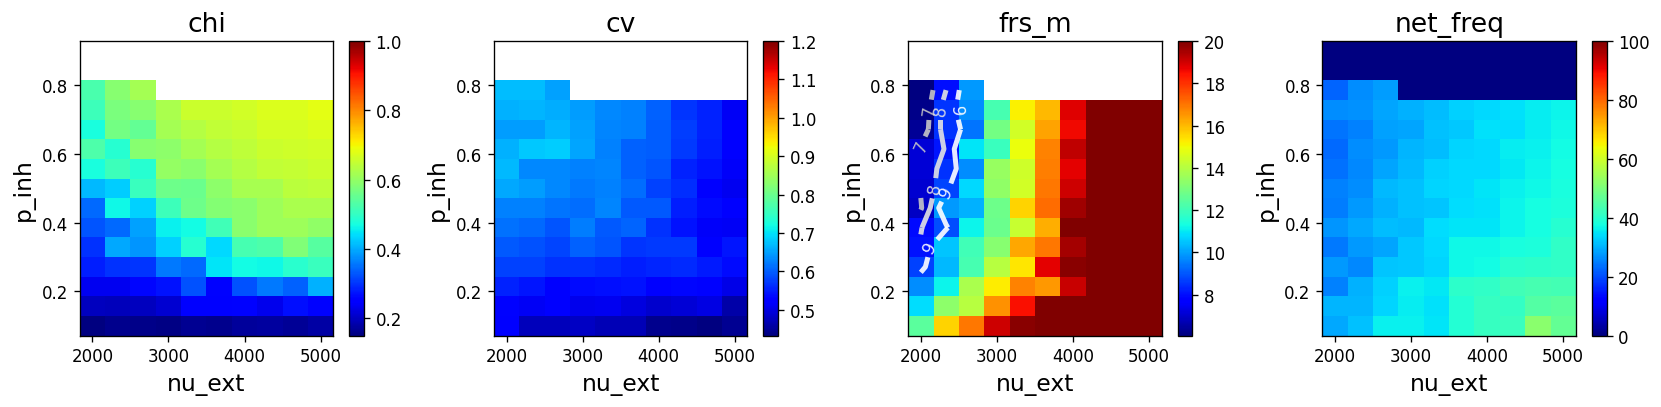

In [240]:
na = 3
nb = 1

print(f"a: {obj.controls['a_set'][na]}, b: {obj.controls['b_set'][nb]}")

imgs, x, y, axs = draw_summary(obj, vmaxs=(1, 1.2, 20, 100))
c = draw_contour(imgs[2], axs[2], max_fr=10)
plt.show()

In [ ]:
fig, axs = 

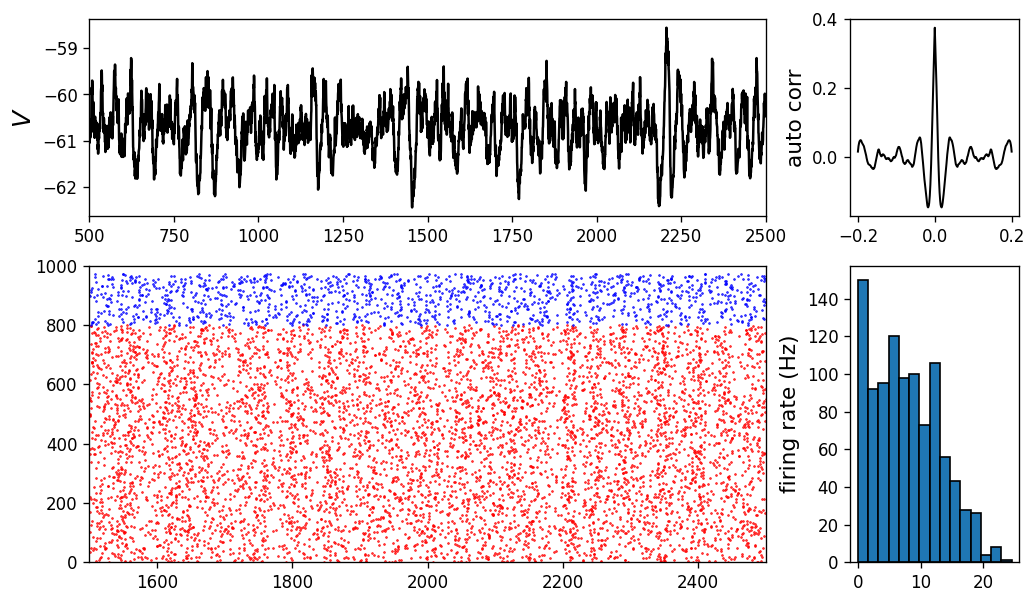

In [225]:
data = obj.load_detail(0, 0, na, nb, 0)
draw_detail(data, xl=(1500, 2500))

- $p_I^f =1$
- $p_I^f = 0.1 * $$p_I^f$

# Fast oscillation

In [251]:
obj = hhtools.SummaryLoader("./async//")
print(obj.summary['chi'].shape)
print(obj.control_names)

Expected number of # results and exact file number are different!: 4883/7200
(30, 30, 2, 4, 3)
['p_exc', 'nu_ext', 'id_set']


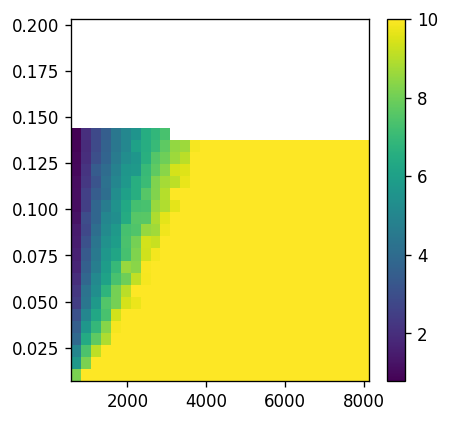

In [256]:
plt.figure(dpi=120, figsize=(4,4))

x = obj.controls["nu_ext"]
y = obj.controls["p_exc"]

plt.pcolormesh(x, y, np.average(obj.summary["frs_m"][:,:,0,:,0], axis=2), vmax=10)
plt.colorbar()
plt.show()


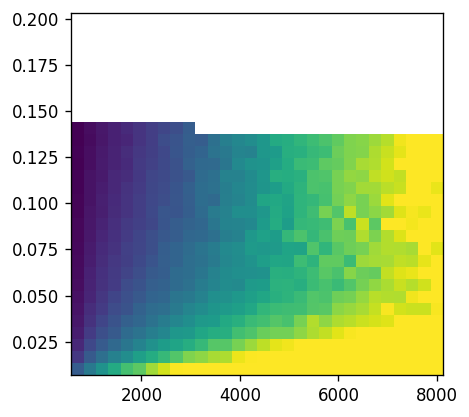

In [258]:
plt.figure(dpi=120, figsize=(4,4))

x = obj.controls["nu_ext"]
y = obj.controls["p_exc"]

plt.pcolormesh(x, y, np.average(obj.summary["frs_m"][:,:,1,:,0], axis=2), vmax=10)

plt.show()

In [261]:
obj = hhtools.SummaryLoader("./pI_nuext_fast_tune//")
print(obj.summary['chi'].shape)
print(obj.control_names)

(30, 30, 5, 3)
['p_inh', 'nu_ext']


(30, 30, 5, 3)
30 30 (30, 30)
30 30 (30, 30)
30 30 (30, 30)
30 30 (30, 30)


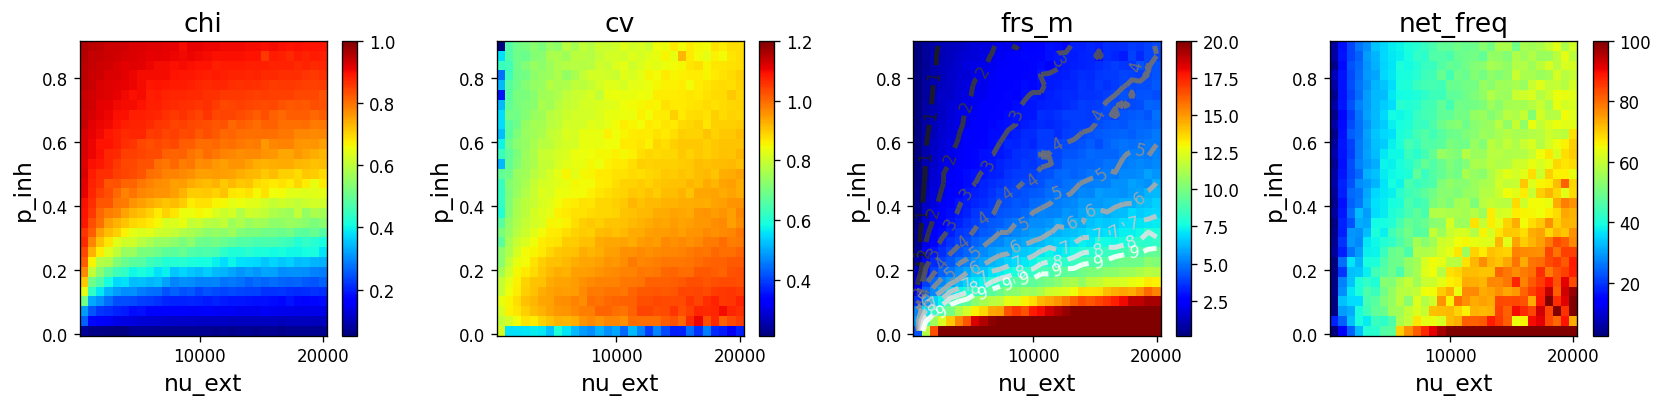

In [262]:
imgs, x, y, axs = draw_summary(obj, vmaxs=(1, 1.2, 20, 100))
c = draw_contour(imgs[2], axs[2], max_fr=10)
plt.show()

In [173]:
!cat pI_nuext_fast_tune/id000000_info.txt

Size: 1000
ntypes: 2
type_range: 0, 0, 
w:
0.050000, 0.050000, 
0.300000, 0.300000, 
taur, taud
0.500000, 1.000000
1.000000, 3.000000
t_lag: 0.000000
nu_pos_mu: 600.000000
nu_pos_sd: 0.000000
w_pos_mu: 0.002000
w_pos_sd: 0.000000
mean indegree:
1.600000, 1.600000, 
2.000000, 2.000000, 
connection prob (out):
0.002000, 0.002000, 
0.010000, 0.010000, 


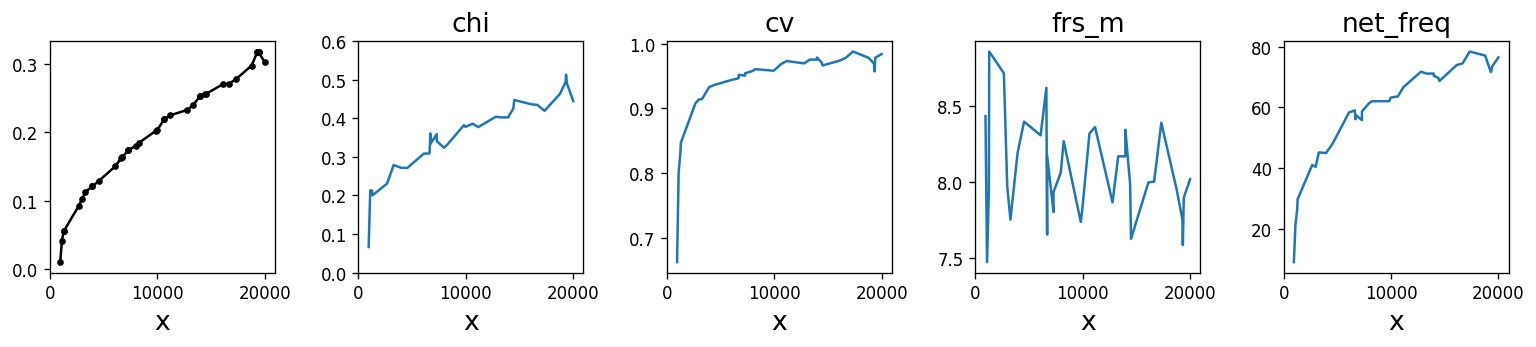

In [165]:
lines, xq, yq = extract_line(imgs, x, y, c, 8)
draw_line_summary(lines, xq, yq, figsize=(13, 3))
plt.show()

chi: [0.063771 0.063053 0.098828]
frs: [11.408998 11.421252 11.360002]
cvs: [0.54972  0.551601 0.54205 ]


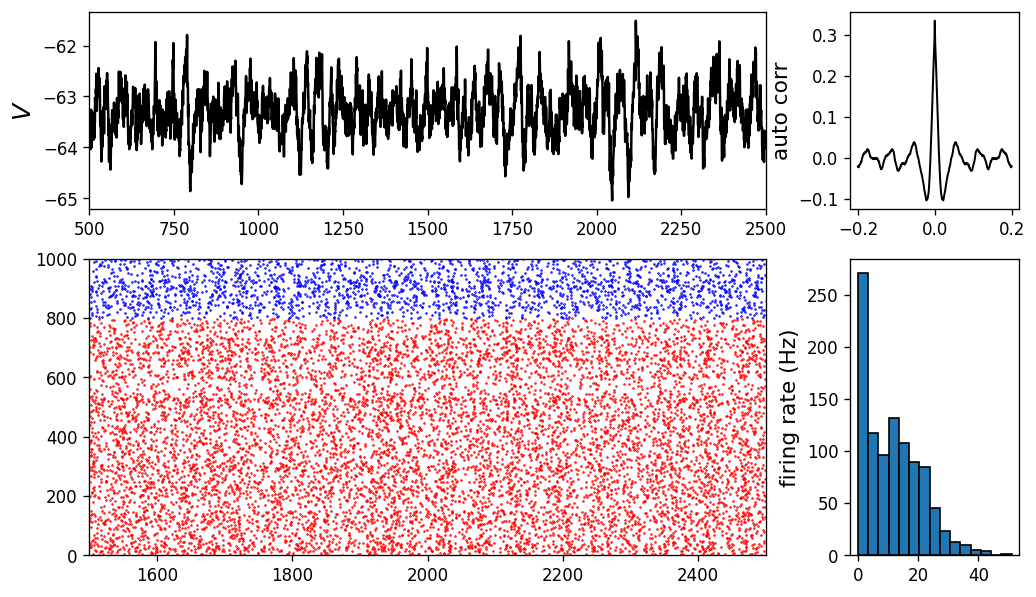

In [169]:
data = get_nearest_point(obj, x, y, xq[0], yq[0])
draw_detail(data, xl=(1500, 2500))

chi: [0.479828 0.480477 0.481171]
frs: [7.89879  7.909496 7.856   ]
cvs: [0.954803 0.952872 0.962488]


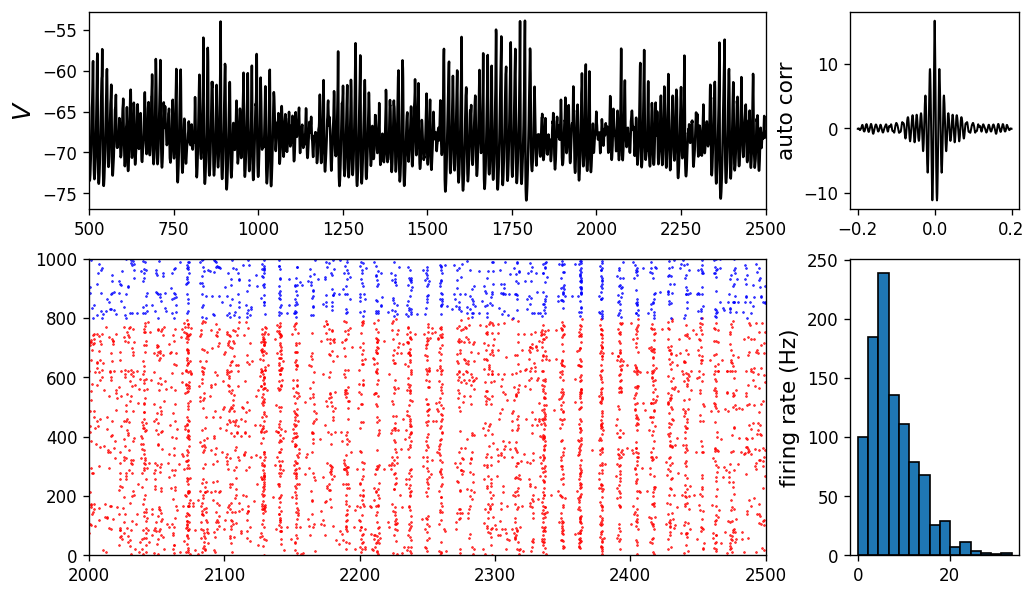

In [171]:
data = get_nearest_point(obj, x, y, xq[-1], yq[-1])
draw_detail(data, xl=(2000, 2500))

In [264]:
obj = hhtools.SummaryLoader("./pI_nuext_slow_ver5//")
print(obj.summary['chi'].shape)
print(obj.control_names)

(15, 15, 2, 3)
['p_inh', 'nu_ext']


(15, 15, 2, 3)
15 15 (15, 15)
15 15 (15, 15)
15 15 (15, 15)
15 15 (15, 15)


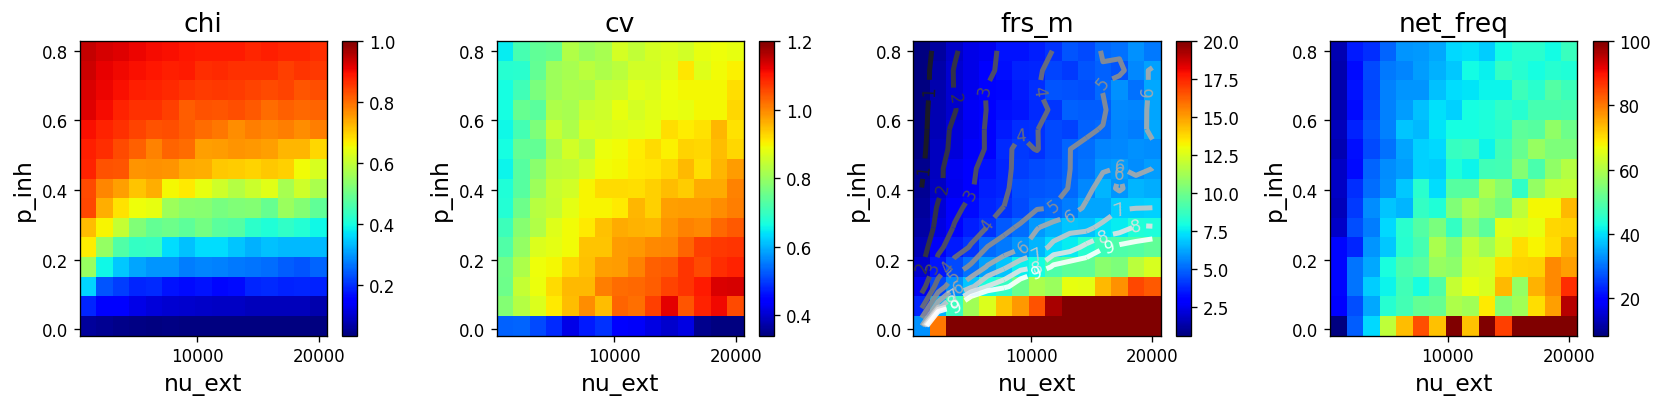

In [265]:
imgs, x, y, axs = draw_summary(obj, vmaxs=(1, 1.2, 20, 100))
c = draw_contour(imgs[2], axs[2], max_fr=10)
plt.show()

In [263]:
!cat pI_nuext_slow_ver5/id000000_info.txt

Size: 1000
ntypes: 2
type_range:
w:
0.060000, 0.060000, 
0.120000, 0.120000, 
taur, taud
0.300000, 1.000000
1.000000, 5.000000
t_lag: 0.000000
nu_pos_mu: 1000.000000
nu_pos_sd: 0.000000
w_pos_mu: 0.002000
w_pos_sd: 0.000000
mean indegree:
0.640000, 0.640000, 
2.000000, 2.000000, 
connection prob (out):
0.000800, 0.000800, 
0.010000, 0.010000, 


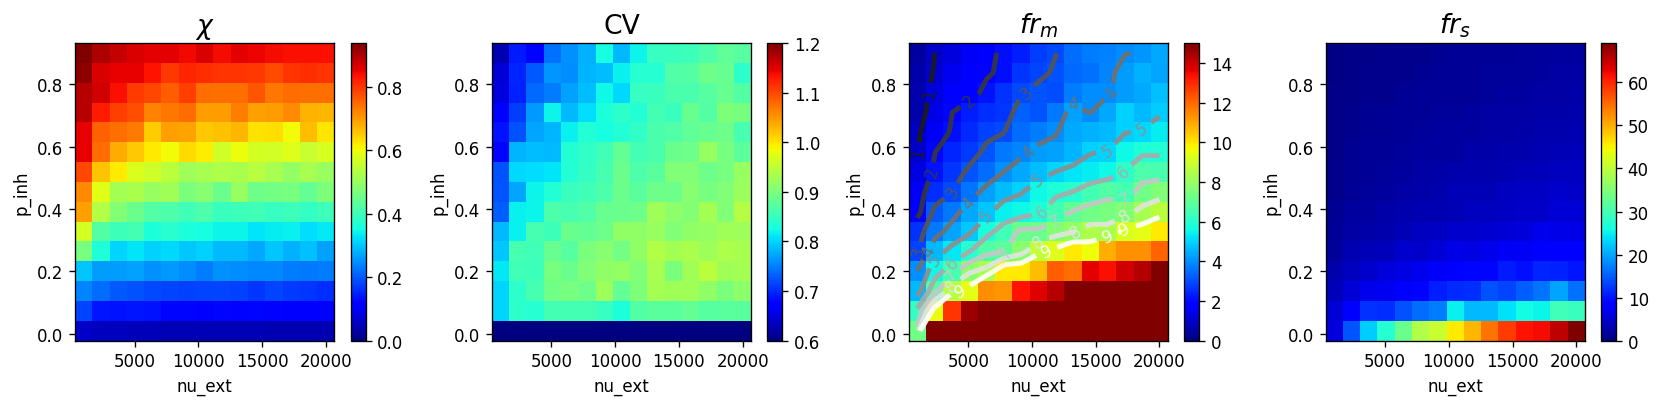

In [20]:
def draw_im(var_name, vmax=None, vmin=None):
    im = np.average(obj.summary[var_name][:,:,:,0], axis=2)
    vary = "p_inh"
    varx = "nu_ext"
    
    y = obj.controls[vary]
    x = obj.controls[varx]
    plt.pcolormesh(x, y, im, cmap="jet", vmin=vmin, vmax=vmax)
    # plt.plot(x_fit, y_fit, 'k')
    # hhtools.imshow_xy(im, x=x, y=y, cmap="jet", vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.xlabel(varx)
    plt.ylabel(vary)
    return im, x, y

fig, axs = plt.subplots(1, 4, dpi=120, figsize=(14, 3.5))
plt.axes(axs[0]); im_chi, _, _ = draw_im("chi", vmax=None, vmin=0); plt.title(r"$\chi$", fontsize=16)
plt.axes(axs[1]); draw_im("cv", vmax=1.2, vmin=0.6); plt.title(r"CV", fontsize=16)
plt.axes(axs[2]);

frs = np.arange(10)
im_frs, x, y = draw_im("frs_m", vmax=15, vmin=0);  plt.title(r"$fr_{m}$", fontsize=16)
c = plt.contour(x, y, im_frs, frs, linewidths=3, alpha=0.9, cmap="gray", nchunk=5)
axs[2].clabel(c, inline=1, fontsize=10)

plt.axes(axs[3]); draw_im("frs_s", vmax=None, vmin=0);  plt.title(r"$fr_{s}$", fontsize=16)
plt.tight_layout()
plt.show()

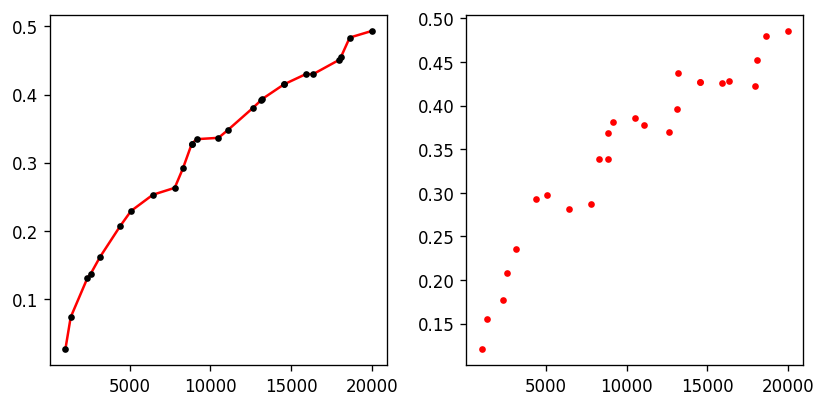

In [23]:
num_fr = 7
xc_tmp, yc_tmp = [], []
for p in c.collections[num_fr].get_paths():
    v = p.vertices
    xc_tmp.extend(v[:,0])
    yc_tmp.extend(v[:,1])
xc_tmp = np.array(xc_tmp)
yc_tmp = np.array(yc_tmp)

ind = np.argsort(xc_tmp)
xc_tmp = xc_tmp[ind]
yc_tmp = yc_tmp[ind]

chi_line, xq, yq = hhtools.extract_value_on_line(im_chi, x, y, xc_tmp, yc_tmp)

plt.figure(dpi=120, figsize=(7,3.5))
plt.subplot(121)
plt.plot(xc_tmp, yc_tmp, 'k.')
plt.plot(xq, yq, 'r', zorder=-1)

plt.subplot(122)
plt.plot(xq, chi_line, 'r.')

plt.tight_layout()
plt.show()

# Test

In [26]:
def get_net_freq(obj):
    nsize = np.shape(obj.summary["chi"])
    im_osc = np.zeros([nsize[0], nsize[1], nsize[2], nsize[3], 1])
    for n1 in range(nsize[0]):
        for n2 in range(nsize[1]):
            for n3 in range(nsize[2]):
                for n4 in range(nsize[3]):
                    try:
                        data = obj.load_detail(n1, n2, n3, n4)
                        im_osc[n1, n2, n3, n4, 0] = hhtools.get_network_frequency(data['vlfp'][0])
                    except:
                        pass
    obj.summary["net_freq"] = im_osc
    

def draw_summary(obj, dpi=120, figsize=(14, 3.5), vmins=None, vmaxs=None):
    if "net_freq" not in obj.summary.keys():
        print(obj.summary["chi"].shape)
        get_net_freq(obj)
        
    vary = "p_exc"
    varx = "nu_ext"
    
    y = obj.controls[vary]
    x = obj.controls[varx]
    
    imgs = []
    f = lambda vrange, n: None if (vrange is None) else vrange[n]
    
    fig, axs = plt.subplots(1, 4, dpi=dpi, figsize=figsize)
    for n, var in enumerate(["chi", "cv", "frs_m", "net_freq"]):
        # need to be set
        im = np.average(obj.summary[var][:,:,ntype,0], axis=2)
        # print(len(x), len(y), im.shape)
        
        imgs.append(im)
        plt.axes(axs[n])
        plt.pcolormesh(x, y, im, cmap="jet", vmin=f(vmins, n), vmax=f(vmaxs, n))
        plt.colorbar()
        plt.xlabel(varx, fontsize=14)
        plt.ylabel(vary, fontsize=14)
        plt.title(var, fontsize=16)
    
    plt.tight_layout()
    
    return imgs, x, y, axs

In [41]:
obj = hhtools.SummaryLoader("./pE_nuext_twopop/")
print(obj.summary['chi'].shape)
print(obj.control_names)

Expected number of # results and exact file number are different!: 4055/5400
(30, 30, 2, 3, 3)
['p_exc', 'nu_ext', 'id_set']


(30, 30, 2, 3, 3)


<a list of 51 text.Text objects>

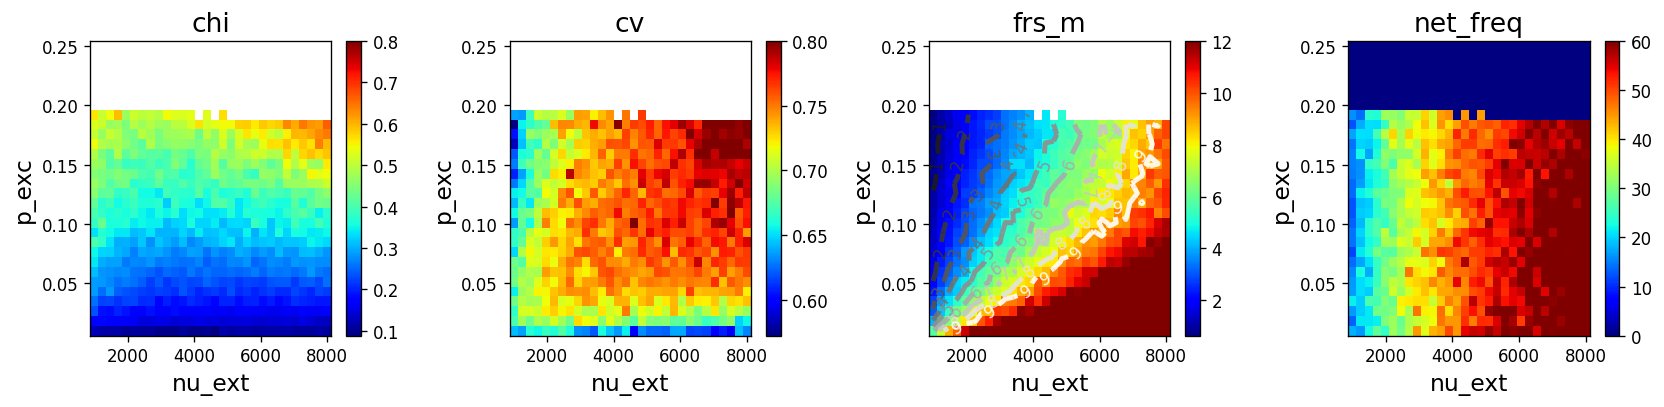

In [42]:
ntype = 0
imgs, x, y, axs = draw_summary(obj, vmaxs=[0.8, 0.8, 12, 60])
plt.axes(axs[2])
c = plt.contour(x, y, imgs[2], np.arange(10), linewidths=3, alpha=0.9, cmap="gray", nchunk=5)
axs[2].clabel(c, inline=1, fontsize=10)

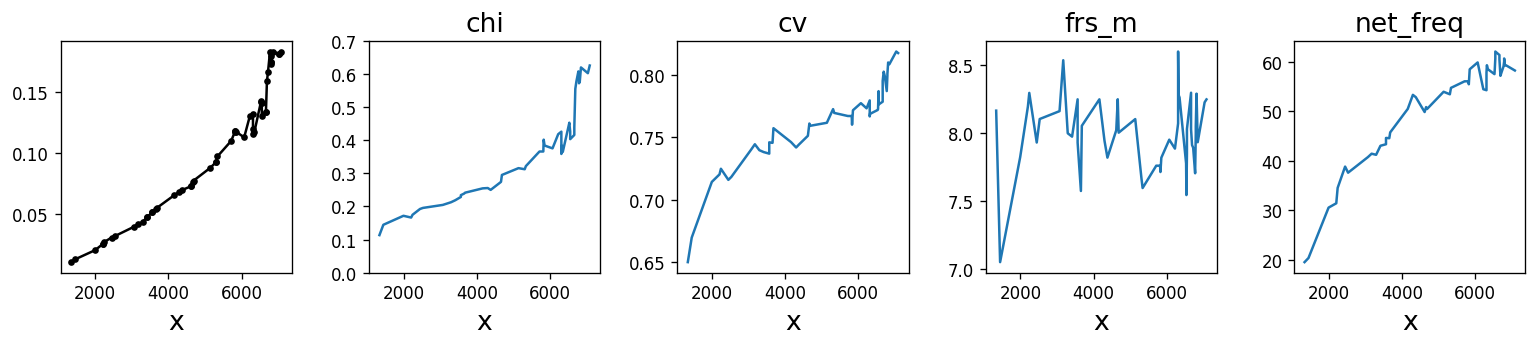

In [43]:
lines, xq, yq = extract_line(imgs, x, y, c, 8)
draw_line_summary(lines, xq, yq, figsize=(13, 3))
plt.show()

<a list of 69 text.Text objects>

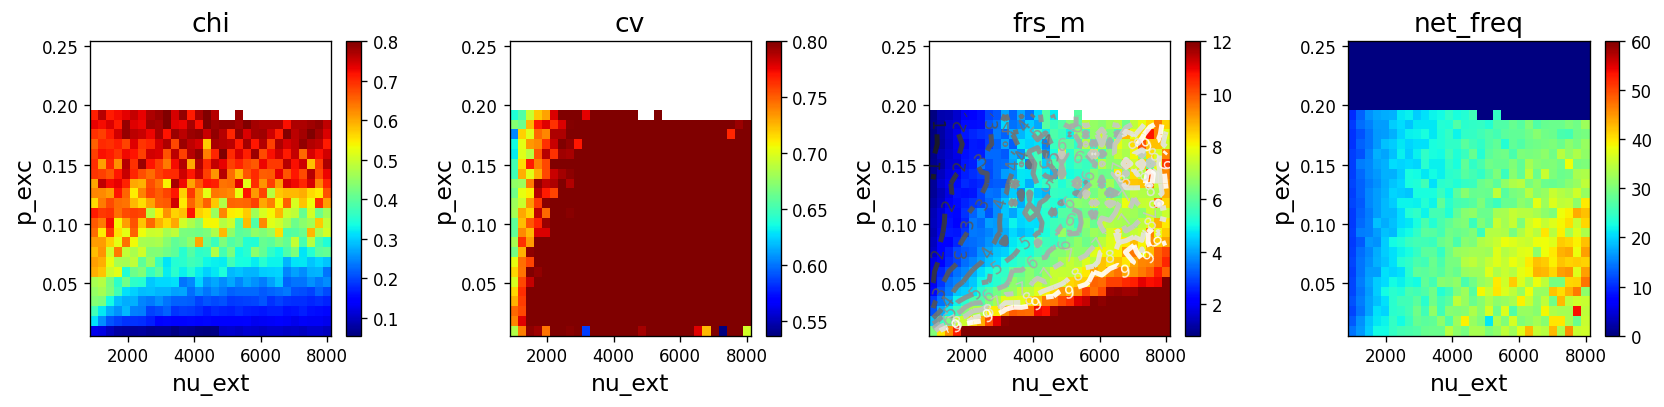

In [44]:
ntype = 1
imgs, x, y, axs = draw_summary(obj, vmaxs=[0.8, 0.8, 12, 60])
plt.axes(axs[2])
c = plt.contour(x, y, imgs[2], np.arange(10), linewidths=3, alpha=0.9, cmap="gray", nchunk=5)
axs[2].clabel(c, inline=1, fontsize=10)

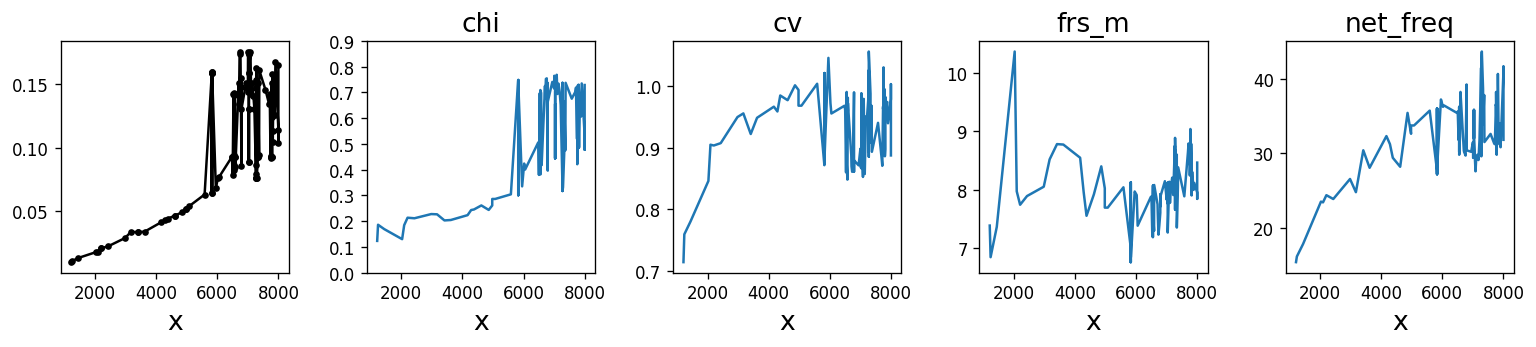

In [40]:
lines, xq, yq = extract_line(imgs, x, y, c, 8)
draw_line_summary(lines, xq, yq, figsize=(13, 3))
plt.show()

# slow oscillation

In [243]:
def get_net_freq(obj):
    nsize = np.shape(obj.summary["chi"])
    print(nsize)
    im_osc = np.zeros([nsize[0], nsize[1], nsize[2], 1])
    for n1 in range(nsize[0]):
        for n2 in range(nsize[1]):
            for n3 in range(nsize[2]):
                try:
                    data = obj.load_detail(n1, n2, 0)
                    im_osc[n1, n2, n3, 0] = hhtools.get_network_frequency(data['vlfp'][0])
                except:
                    pass
    obj.summary["net_freq"] = im_osc
    
    

def draw_summary(obj, dpi=120, figsize=(14, 3.5), vmins=None, vmaxs=None):
    if "net_freq" not in obj.summary.keys():
        print(obj.summary["chi"].shape)
        get_net_freq(obj)
        
    vary = "p_inh"
    varx = "nu_ext"
    
    y = obj.controls[vary]
    x = obj.controls[varx]
    
    imgs = []
    f = lambda vrange, n: None if (vrange is None) else vrange[n]
    
    fig, axs = plt.subplots(1, 4, dpi=dpi, figsize=figsize)
    for n, var in enumerate(["chi", "cv", "frs_m", "net_freq"]):
        # need to be set
        im = np.average(obj.summary[var][:,:,:,0], axis=2)
        print(len(x), len(y), im.shape)
        
        imgs.append(im)
        plt.axes(axs[n])
        plt.pcolormesh(x, y, im, cmap="jet", vmin=f(vmins, n), vmax=f(vmaxs, n))
        plt.colorbar()
        plt.xlabel(varx, fontsize=14)
        plt.ylabel(vary, fontsize=14)
        plt.title(var, fontsize=16)
    
    plt.tight_layout()
    
    return imgs, x, y, axs


def get_net_freq(obj):
    nsize = np.shape(obj.summary["chi"])
    im_osc = np.zeros([nsize[0], nsize[1], 1, 1])
    for n1 in range(nsize[0]):
        for n2 in range(nsize[1]):
            try:
                data = obj.load_detail(n1, n2, 0)
                im_osc[n1, n2, 0] = hhtools.get_network_frequency(data['vlfp'][0])
            except:
                pass
    obj.summary["net_freq"] = im_osc

In [244]:
obj = hhtools.SummaryLoader("./async_fast/")
print(obj.summary['chi'].shape)
print(obj.control_names)

Expected number of # results and exact file number are different!: 75/100
(10, 10, 1, 3)
['p_inh', 'nu_ext']


(10, 10, 1, 3)
10 10 (10, 10)
10 10 (10, 10)
10 10 (10, 10)
10 10 (10, 10)


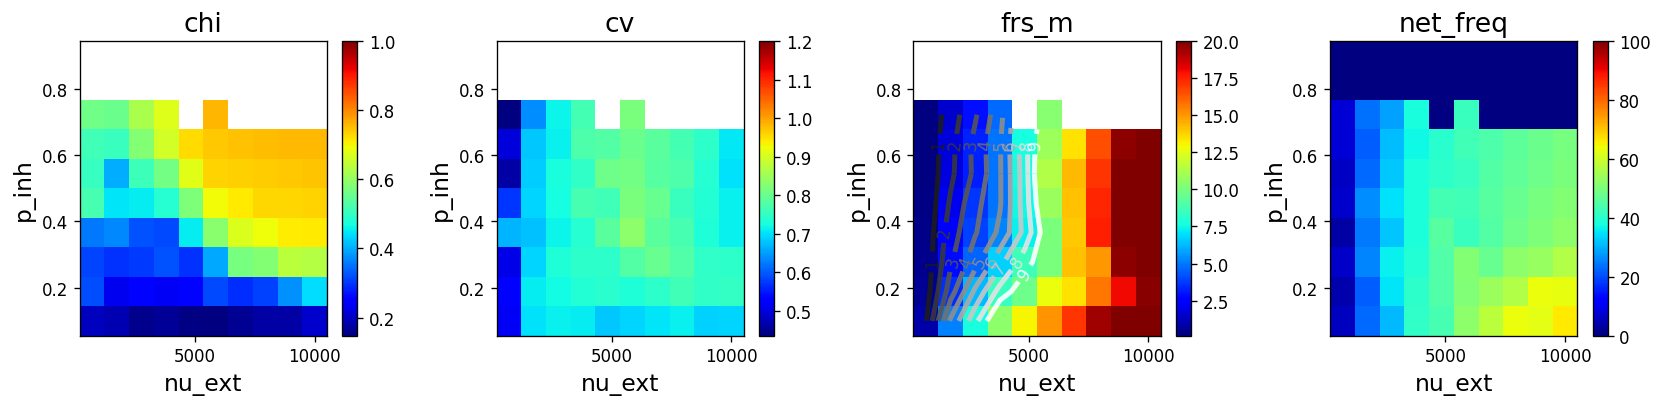

In [245]:
imgs, x, y, axs = draw_summary(obj, vmaxs=(1, 1.2, 20, 100))
c = draw_contour(imgs[2], axs[2], max_fr=10)
plt.show()

In [246]:
import multiprocessing
from multiprocessing import Pool

In [250]:
def print_test(n):
    print("Hello from %d"%(n))

    
def test(nid):
    # with Pool(4) as p:
        # ns = [nid+i for i in range(4)]
    print_test(nid)


with Pool(4) as p:
    nids = [10*i for i in range(4)]
    
    p.map(test, nids)
    

Hello from 0Hello from 10Hello from 30


Hello from 20
